Benjamin Ye  
CS/CNE/EE 156a: Learning Systems (Fall 2023)  
October 23, 2023

## Homework 4

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, globals()['_dh'][0].resolve().parent)
from cs156a import (
    vapnik_chervonenkis_bound, rademacher_bound,
    parrondo_van_den_broek_bound, devroye_bound, generate_data
)

mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

### Problems 2–3


[HW4 P2–3]
Generalization bounds for d_vc=50 and delta=0.05:
  N=10,000:
    Vapnik–Chervonenkis: 0.632
    Rademacher: 0.331
    Parrondo–van den Broek: 0.224
    Devroye: 0.215
  N=5:
    Vapnik–Chervonenkis: 13.828
    Rademacher: 7.049
    Parrondo–van den Broek: 5.101
    Devroye: 5.593


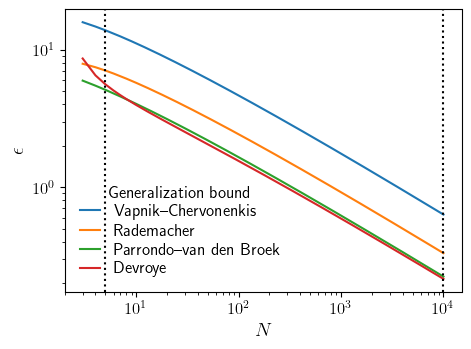

In [4]:
d_vc = 50
delta = 0.05
m_H = lambda N: N ** d_vc
Ns = np.arange(3, 10_001, dtype=float)
bounds = {
    "Vapnik–Chervonenkis": vapnik_chervonenkis_bound(m_H, Ns, delta),
    "Rademacher": rademacher_bound(m_H, Ns, delta),
    "Parrondo–van den Broek": parrondo_van_den_broek_bound(m_H, Ns, delta),
    "Devroye": devroye_bound(lambda N: d_vc * np.log(N), Ns, delta, log=True)
}

_, ax = plt.subplots()
for l, b in bounds.items():
    ax.plot(Ns, b, label=l)
ax.set_yscale("log")
ylim = ax.get_ylim()

print(f"\n[HW4 P2–3]\nGeneralization bounds for {d_vc=} and {delta=}:")
for N in (10_000, 5):
    i = np.where(Ns == N)[0][0]
    print(f"  {N=:,}:")
    for l, b in bounds.items():
        print(f"    {l}: {b[i]:.3f}")
    ax.plot((N, N), ylim, "k:")

ax.legend(title="Generalization bound")
ax.set_xlabel("$N$")
ax.set_xscale("log")
ax.set_ylabel("$\epsilon$")
ax.set_ylim(ylim)
plt.show()

#### Problems 4–7

In [3]:
n_runs = 10_000_000
hs = {
    # h(x): ((a(x_in, y_in), b(x_in, y_in)),
    #        bias(x_out, y_out, a_avg, b_avg),
    #        var(x_out, a, a_avg, b, b_avg), 
    #        fmt(a_avg, b_avg))
    "b": (
        lambda x, y: (None, (y[::2] + y[1::2]) / 2),
        lambda xt, yt, ah, bh: ((bh - yt) ** 2).mean(),
        lambda xt, a, ah, b, bh: ((np.tile(b, (2, 1)) - bh) ** 2).mean(),
        lambda ah, bh: f"{bh:.2f}"
    ), 
    "ax": (
        lambda x, y: (
            (x[::2] * y[::2] + x[1::2] * y[1::2]) 
            / (x[::2] ** 2 + x[1::2] ** 2),
            None
        ),
        lambda xt, yt, ah, bh: ((ah * xt - yt) ** 2).mean(),
        lambda xt, a, ah, b, bh: (
            ((np.tile(a, (2, 1)) - ah) * xt) ** 2
        ).mean(),
        lambda ah, bh: f"{ah:.2f}x"
    ),
    "ax+b": (
        lambda x, y: (
            (y[::2] - y[1::2]) / (x[::2] - x[1::2]),
            (x[::2] * y[1::2] - x[1::2] * y[::2]) / (x[::2] - x[1::2])
        ),
        lambda xt, yt, ah, bh: ((ah * xt + bh - yt) ** 2).mean(),
        lambda xt, a, ah, b, bh: (
            ((np.tile(a, (2, 1)) - ah) * xt + np.tile(b, (2, 1)) - bh) ** 2
        ).mean(),
        lambda ah, bh: f"{ah:.2f}x{'+' if bh >= 0 else ''}{bh:.2f}"
      ),
    "ax^2": (
        lambda x, y: (
            (x[::2] * y[::2] + x[1::2] * y[1::2]) 
            / (x[::2] ** 3 + x[1::2] ** 3),
            None
        ),
        lambda xt, yt, ah, bh: ((ah * xt ** 2 - yt) ** 2).mean(),
        lambda xt, a, ah, b, bh: (
            ((np.tile(a, (2, 1)) - ah) * xt ** 2) ** 2
        ).mean(),
        lambda ah, bh: f"{ah:.2f}x^2"
    ),
    "ax^2+b": (
        lambda x, y: (
            (y[::2] - y[1::2]) / (x[::2] ** 2 - x[1::2] ** 2),
            (x[::2] ** 2 * y[1::2] - x[1::2] ** 2 * y[::2]) 
            / (x[::2] ** 2 - x[1::2] ** 2)
        ),
        lambda xt, yt, ah, bh: ((ah * xt ** 2 + bh - yt) ** 2).mean(),
        lambda xt, a, ah, b, bh: (
            ((np.tile(a, (2, 1)) - ah) * xt ** 2 + np.tile(b, (2, 1)) - bh) ** 2
        ).mean(),
        lambda ah, bh: f"{ah:.2f}x^2{'+' if bh >= 0 else ''}{bh:.2f}"
    )
}
x, y = generate_data(2 * n_runs, lambda x: np.sin(np.pi * x), 1)
x_test, y_test = generate_data(2 * n_runs, lambda x: np.sin(np.pi * x), 1)

print("\n[HW4 P4–7]\nBias and variance for f(x)=sin(pi*x):")
for i, (h, (f_ab, f_bias, f_var, fmt)) in enumerate(hs.items()):
    as_, bs = f_ab(x, y)
    a_avg = None if as_ is None else as_.mean()
    b_avg = None if bs is None else bs.mean()
    bias = f_bias(x_test, y_test, a_avg, b_avg)
    var = f_var(x_test, as_, a_avg, bs, b_avg)
    print(f"  [{chr(97 + i)}] h(x)={h}: "
          f"g(x)={fmt(a_avg, b_avg)}, {bias=:.3f}, {var=:.3f}")


[HW4 P4–7]
Bias and variance for f(x)=sin(pi*x):
  [a] h(x)=b: g(x)=0.00, bias=0.500, var=0.250
  [b] h(x)=ax: g(x)=1.43x, bias=0.271, var=0.237
  [c] h(x)=ax+b: g(x)=0.78x+0.00, bias=0.207, var=1.678
  [d] h(x)=ax^2: g(x)=0.81x^2, bias=0.631, var=23814620.804
  [e] h(x)=ax^2+b: g(x)=1.21x^2+0.10, bias=0.884, var=43860178.114
